In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

In [11]:
import importlib
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [ ]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}"):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Testdaten/{fold}/{fname}")
paths[0]  

In [2]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Trainingsdaten/Karotte_Trieb/karotte_trieb_100.jpg'] # 209 previous
paths = demo_img

In [3]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
 
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    try:
        ############################# Find Contours in image and draw a bounding box ##################################
        vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, object_area=500)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:  # makes sure there is only one bounding box in the image
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = prep.draw_contours(vegi_sq_BGR_original, box_size)

        ############################# Get pixel size from the bounding box (hight and width) ##################################
        h, w = [int(l) for l in prep.get_size_box(box)]
        
        ############################# Calculate the Ratio Area Feature ##################################
        ratio_area_box = 0
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        ############################# Crop the including area from the bounding box (our ROI) ##################################
        if not prep.is_box_rotated(box):
            #crop img directly
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

        ############################# Do a binary segmentation only with the roi  ##################################
        cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
        #print("Segmented BINARY From Cop NEW")
        #show_image_plt(cropped_segmented_binary_2)

        ############################# Apply the binary mask on the cropped image  ##################################
        cropped_vegi_segmented_rgb_2 = prep.color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)

        ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
        num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

        ############################# Apply a green mask on the image ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        ############################# Calculates the number of green pixels feature  ##################################
        amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
        amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)
        ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
        center, ret, label = prep.get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
        R, G, B = np.max(center, axis=0)
        
        a = path.split(".")
        b = a[0].split("_")
        img_name = f"{vegi_label}_{b[-1]}"
        vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
        
        if i < 3:
            print(vegis_df)
        
    except Exception as e:
        print(f"########## Error: {e}")
        error_counter += 1
    

   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    259    110  108  88  50          2762                1477    0.000614   

   circularity  keypoints  mean keypoints          Label              Image  
0     0.154427         57        7.554189  Karotte_Trieb  Karotte_Trieb_100  


The resized image to 256x256 pixels


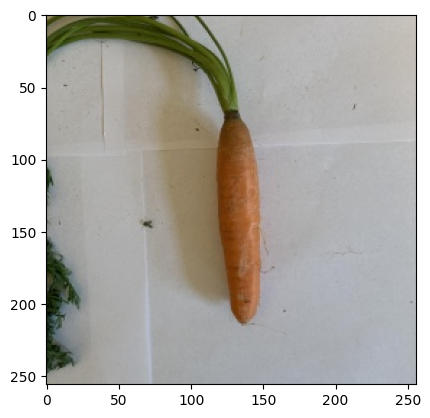

Shows the bounding box which was drawed around the founded contours


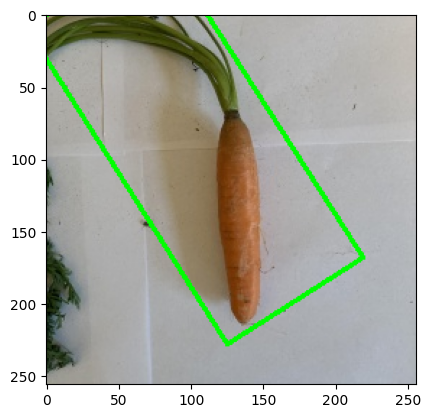

Segmented Binary Image 


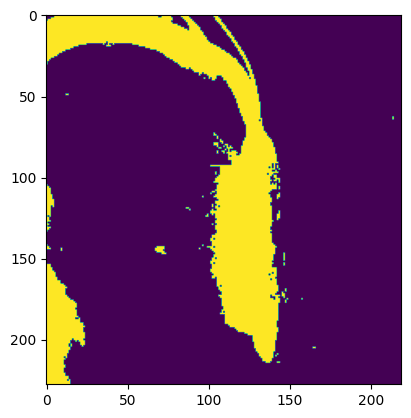

Segmented Image after applying the binary mask


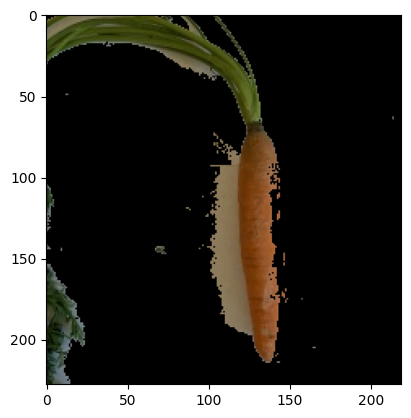

Shows the green color mask to get only the green pixels from the image


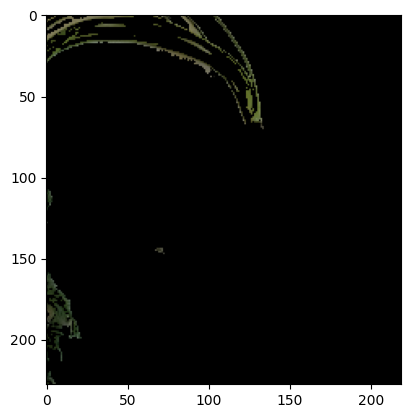

In [4]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [ ]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")

In [7]:
import math

In [8]:
v1 = box[1] - box[0]
print("v1: ", v1)

reference_point = np.array([100, box[0][1]])
print(reference_point)
v_horizontal = reference_point - box[0]
print("v_horiz: ", v_horizontal)
assert(v_horizontal[1] == 0)
length_p0_p1 = np.linalg.norm(v1)
scalar_product = np.dot(v1, v_horizontal)
magnitude =  length_p0_p1 * np.linalg.norm(v_horizontal)
angle_cos = round(math.degrees(math.acos(scalar_product / magnitude)), 2)
print(angle_cos)
assert(angle_cos <= 90.0 and angle_cos >= 0.0)  # I think there angle should always between 0 and 90. Because I always take the most left corner

length_p0_p3 = np.linalg.norm(box[0] - box[3])
print("length p0_p1: ", length_p0_p1)
print("length p0_p3: ", length_p0_p3)

# Idea is get the short sides of rectangle, find the middle and draw a parallel line from the middle point to the opposite side
if length_p0_p1 < length_p0_p3:
    # length_p0_p1 is the short one
    pass
else:
    # length_p0_p1 is the long one
    middle_point = np.array([(box[2][0] + box[1][0])/2, (box[2][1] + box[1][1])/2])
    print("Middle_point: ", middle_point)
    # Additional check: If one coordiante is negative then try the oposite side 
    

v1:  [ 93 -59]
[100   9]
v_horiz:  [114   0]
32.39
length p0_p1:  110.13627921806692
length p0_p3:  259.38774065094134


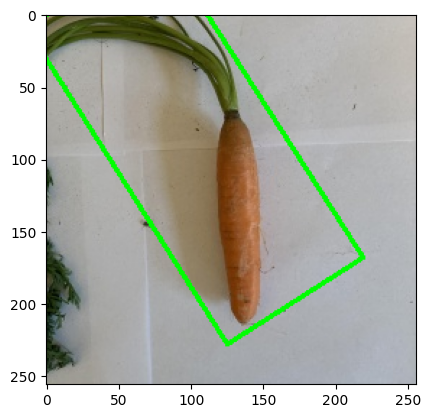

In [9]:
show_image_plt(vegi_with_box_rgb)

In [12]:
#box_test = np.array([[14, 9],
# [ 79, 50],
# [260, 168],
# [125, 240]])
box_test = box.copy()
print("Box: ", box_test)
# figure out the correct case. Find the points which are outside the image
outside_count = 0
outside_count = sum(1 for arr in box_test if (arr < 0).any() or (arr > 255).any())
#for arr in box:
#    if (arr < 0).any() or (arr > 255).any():
#        outside_count += 1
print("Outside count: ", outside_count)

p0, p1, p2, p3 = box_test[0], box_test[1], box_test[2], box_test[3]
# Calculate the directions of the vectors, once
u_0_1 = p1 - p0
u_0_3 = p3 - p0
print(f"Vector u_0_1: {u_0_1} | Vector u_0_3: {u_0_3}")

if outside_count == 1:
    new_box = prep.case_one_point_outside(box_test, u_0_1)
elif outside_count == 2:
    new_box = prep.case_2_points_outside(box_test, u_0_1, u_0_3)
elif outside_count >= 3:
    # Assumption: Area of bounding box is probably similar to the area of the img. Just draw a new box with edge points in the middle of each side of the img
    # TODO Important: but keep the orignal angle from the box. rect[2]
    h = vegi_sq_BGR_original.shape[0]
    new_box = np.array([[0, h // 2], [h // 2, 0],  [255, h // 2], [h // 2, 255]])
# rotate the bounding box
print("New_box:", new_box)

# case 3

Box:  [[-14   9]
 [ 79 -50]
 [219 168]
 [125 228]]
Outside count:  2
Vector u_0_1: [ 93 -59] | Vector u_0_3: [139 219]
This is case 2
point_idx_1:  0 point_idx_2:  1
eps:  0.10071942446043165
vector x:  139
vector y:  219
New Point x= 0 y= 31
New Point x= 110 y= 0
Length l_0= 26.076809620810597 and l_1= 58.83026432033091
New_box: [[ 17  59]
 [110   0]
 [219 168]
 [125 228]]


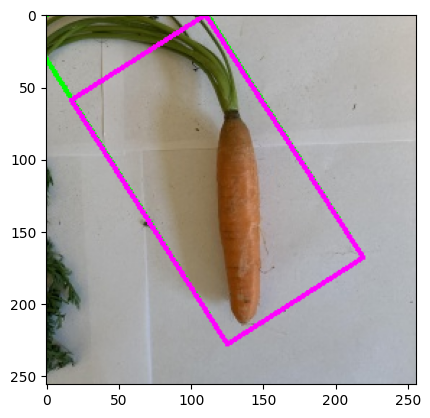

In [14]:
vegi_new_box = vegi_with_box_rgb.copy()

vegi_new = cv2.line(vegi_new_box, new_box[0], new_box[1], (255, 0, 255), 2)
vegi_new = cv2.line(vegi_new, new_box[1], new_box[2], (255, 0, 255), 2)
vegi_new = cv2.line(vegi_new, new_box[2], new_box[3], (255, 0, 255), 2)
vegi_new = cv2.line(vegi_new, new_box[3], new_box[0], (255, 0, 255), 2)
prep.show_image_plt(vegi_new)

Center X:  128
Center Y:  128


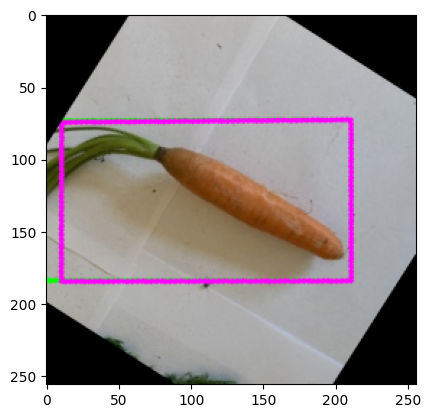

In [83]:
centerX = vegi_new_box.shape[1] // 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] // 2
print("Center Y: ", centerY)
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)
rotated_2 = cv2.warpAffine(vegi_new_box, M, (vegi_new_box.shape[1], vegi_new_box.shape[0]))

show_image_plt(rotated_2)

In [66]:
points = [(point[0], point[1], 1) for point in new_box]
points

[(0, 128, 1), (128, 0, 1), (255, 128, 1), (128, 255, 1)]

In [84]:
centerX = vegi_new_box.shape[1] / 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] / 2
print("Center Y: ", centerY)

points = [(point[0], point[1], 1) for point in new_box]
# Definiere den Punkt (Pixel)
#pixel = np.array([255, 83, 1])
#pixel = (255, 83, 1)
# Definiere die Rotationsmatrix
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)

rotated_points = []
# Wende die Rotationsmatrix auf den Punkt an
for point in points:
    rotated_pixel = np.dot(M, point)

# Konvertiere die homogene Koordinate zurück in eine normale Koordinate
    #rotated_pixel = rotated_pixel.astype(int)
    # Die Koordinaten des rotierten Punktes
    rotated_x, rotated_y = int(rotated_pixel[0]), int(rotated_pixel[1])
    #print("Rotierter Punkt:", (rotated_x, rotated_y))
    rotated_points.append((rotated_x, rotated_y))
rotated_points

Center X:  128.0
Center Y:  128.0


[(10, 184), (10, 74), (210, 72), (210, 184)]

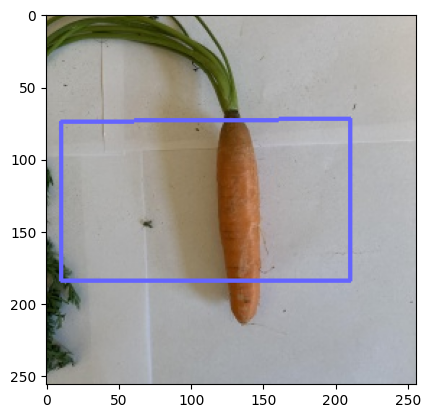

In [85]:
vegi_new_box = vegi_BGR.copy()
vegi_new_box = cv2.cvtColor(vegi_new_box, cv2.COLOR_BGR2RGB)

vegi_new_box = cv2.line(vegi_new_box, rotated_points[0], rotated_points[1], (100, 100, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, rotated_points[1], rotated_points[2], (100, 100, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, rotated_points[2], rotated_points[3], (100, 100, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, rotated_points[3], rotated_points[0], (100, 100, 255), 2)
show_image_plt(vegi_new_box)

In [62]:
box

array([[-14, 217],
       [120,  -7],
       [273,  84],
       [139, 309]], dtype=int64)

In [13]:
# Only if box is rotated - check it with the box_rotated function()
po, p1, p2, p3 = box[0], box[1], box[2], box[3]
print(po, p1, p2, p3)
# Calculate the directions of the vectors, once
u_0_1 = p1 - po
print("Vector u_0_1: ", u_0_1)
u_1_2 = p2 - p1
print("Vector u_1_2: ", u_1_2)
po_moved = False
p1_moved = False
#If po_x not within the image
if po[0] < 0: # x coordinate outside the image at left bound
    po_moved = True
    # Move po along the direction of u_0_1
    # p0_new = p0 + eps * u_0_1
    eps = (po[0] * (-1)) / u_0_1[0]
    po_y_new = po[1] + eps * u_0_1[1]
    print(f"New po_x= {0} po_y= {po_y_new}")
    p0_y_new = int(po_y_new)
    print(f"Rounded down: po_y_new= {p0_y_new}")

    if p3[1] > 255: # y coordinate outside the image at lower bound
        # If I have the case every edge point is outside the image, then I have to create a complete new bounding box
        pass

if p1[1] < 0: # y coordinate P1 outside the image at upper bound
    p1_moved = True
    # Move p1 along the direction of u_0_1
    eps = (p1[1] * (-1)) / u_0_1[1]
    p1_x_new = p1[0] + eps * u_0_1[0]
    print(f"New p1_x= {p1_x_new} p1_y= {0}")
    p1_x_new = int(p1_x_new)
    print(f"Rounded down: p1_x_new= {p1_x_new}")

    if p2[0] > 255:
        p2_x_new = 255
        # Create complete new P2 by moving p1 along the direction of u_1_2
        eps = (p2_x_new + (p1_x_new * (-1))) / u_1_2[0]
        p2_y_new = 0 + eps * u_1_2[1]  # p1_y_new = 0
        print(f"New p2_x= {p2_x_new} p2_y= {p2_y_new}")
        p2_y_new = int(p2_y_new)
        print(f"Rounded down: p2_y_new= {p2_y_new}")
    elif p2[1] <= 255:
        # Move p2 along the direction of u = p1_new - p1, and just add the components of u to p2
        u_p1_p1_new = (p1_x_new - int(p1[0]), int(p1[1])*(-1))
        print(u_p1_p1_new, type(u_p1_p1_new))
        p2_x_new = u_p1_p1_new[0] + p2[0]
        p2_y_new = u_p1_p1_new[1] + p2[1]
        print(f"New P2 by moving along direction of (p1, p1_new): p2_x_new= {p2_x_new}, p2_y_new= {p2_y_new}")

p3_y_new = 255
eps = (p3_y_new + (p2_y_new * (-1))) / u_0_1[1]
p3_x_new = int(p2_x_new + eps * u_0_1[0])
print(f"New p3_x= {p3_x_new} p3_y= {p3_y_new}")

[-14   9] [ 79 -50] [219 168] [125 228]
Vector u_0_1:  [ 93 -59]
Vector u_1_2:  [140 218]
New po_x= 0 po_y= 0.11827956989247213
Rounded down: po_y_new= 0
New p1_x= 0.18644067796610386 p1_y= 0
Rounded down: p1_x_new= 0
(-79, 50) <class 'tuple'>
New P2 by moving along direction of (p1, p1_new): p2_x_new= 140, p2_y_new= 218
New p3_x= 81 p3_y= 255


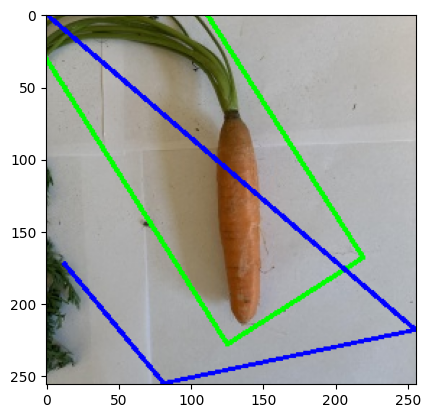

In [14]:
vegi_new_box = vegi_with_box_rgb.copy()

vegi_new = cv2.line(vegi_new_box, (0, p0_y_new), (p1_x_new, 0), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (p1_x_new, 0), (255, p2_y_new), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (255, p2_y_new), (p3_x_new, p3_y_new), (0, 0, 255), 2)
vegi_new = cv2.line(vegi_new, (p3_x_new, p3_y_new), (12, 172), (0, 0, 255), 2)
show_image_plt(vegi_new)

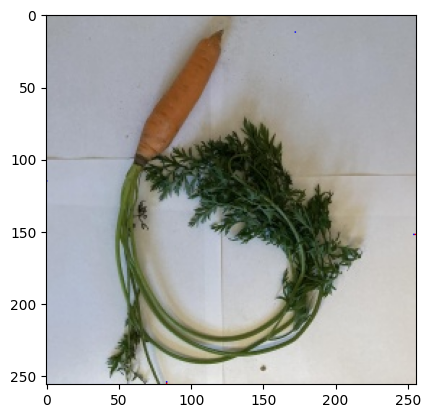

In [120]:
vegi_new_box = vegi_BGR.copy()
vegi_new_box = cv2.cvtColor(vegi_new_box, cv2.COLOR_BGR2RGB)
#vegi_new_box = cv2.line(vegi_new_box, (p1_x_new, 0), (p1_x_new, 0), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (255, p2_y_new), (255, p2_y_new), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (p3_x_new, p3_y_new), (p3_x_new, p3_y_new), (0, 0, 255), 1)
#vegi_new_box = cv2.line(vegi_new_box, (12, 172), (12, 172), (0, 0, 255), 1)
vegi_new_box[p1_x_new][0] = (0, 0, 255)
vegi_new_box[254][p2_y_new] = (0, 0, 255)
vegi_new_box[p3_x_new][254] = (0, 0, 255)
vegi_new_box[12][172] = (0, 0, 255)
show_image_plt(vegi_new_box)

#rotated = imutils.rotate(vegi_new_box, rect[2])

Center X:  128
Center Y:  128


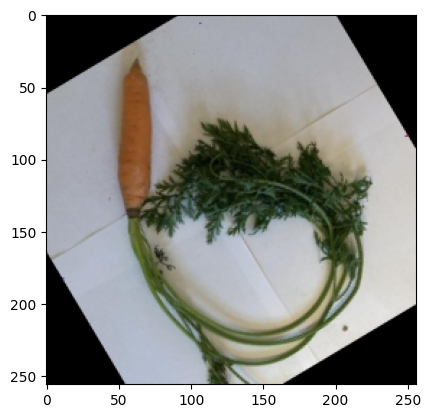

In [123]:
centerX = vegi_new_box.shape[1] // 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] // 2
print("Center Y: ", centerY)
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)
rotated_2 = cv2.warpAffine(vegi_new_box, M, (vegi_new_box.shape[1], vegi_new_box.shape[0]))

show_image_plt(rotated_2)

In [65]:
#p1_x= 115.8125 p1_y= 0
#Rounded down: p1_x_new= 115
#New p2_x= 255 p2_y= 83.26797385620915
#Rounded down: p2_y_new= 83
#New p3_x= 152 p3_y= 255
#p0x = 12, p0y = 172

centerX = vegi_new_box.shape[1] / 2
print("Center X: ", centerX)
centerY = vegi_new_box.shape[0] / 2
print("Center Y: ", centerY)

points = [(12, 172, 1), (115, 0, 1), (255, 83, 1), (152, 255, 1)]
# Definiere den Punkt (Pixel)
#pixel = np.array([255, 83, 1])
#pixel = (255, 83, 1)
# Definiere die Rotationsmatrix
M = cv2.getRotationMatrix2D((centerX, centerY), rect[2], 1.0)

rotated_points = []
# Wende die Rotationsmatrix auf den Punkt an
for point in points:
    rotated_pixel = np.dot(M, point)

# Konvertiere die homogene Koordinate zurück in eine normale Koordinate
    #rotated_pixel = rotated_pixel.astype(int)
    # Die Koordinaten des rotierten Punktes
    rotated_x, rotated_y = rotated_pixel[0], rotated_pixel[1]
    #print("Rotierter Punkt:", (rotated_x, rotated_y))
    rotated_points.append((rotated_x, rotated_y))
rotated_points

Center X:  128.0
Center Y:  128.0


[(50.917177055303156, 225.21233670104078),
 (51.26372985277294, 24.730716842365027),
 (214.01755957365884, 24.293782997391844),
 (213.67100677618902, 224.77540285606756)]

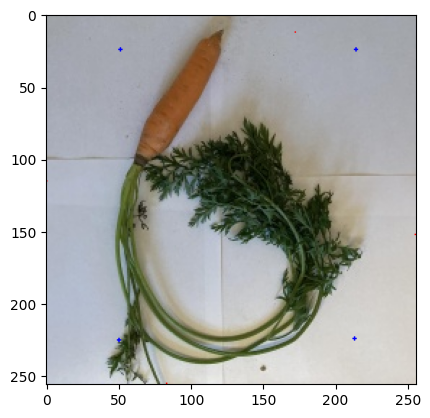

In [141]:
vegi_new_box = vegi_BGR.copy()
vegi_new_box = cv2.cvtColor(vegi_new_box, cv2.COLOR_BGR2RGB)

vegi_new_box = cv2.line(vegi_new_box, (50, 225), (50, 225), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (51, 24), (51, 24), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (214, 24), (214, 24), (0, 0, 255), 2)
vegi_new_box = cv2.line(vegi_new_box, (213, 224), (213, 224), (0, 0, 255), 2)

show_image_plt(vegi_new_box)

In [59]:
from sympy import Symbol, nsolve
import mpmath
#mpmath.mp.dps = 15

x = Symbol('x')
y = Symbol('y')
f1 = 134 * x - 152 - 153 * y
f2 = 193 - 224 * x - 255 - 91 * y
erg = nsolve((f1, f2), (x, y), (-1, 1))
erg

Matrix([
[0.0935307536693496],
[-0.911548228812465]])

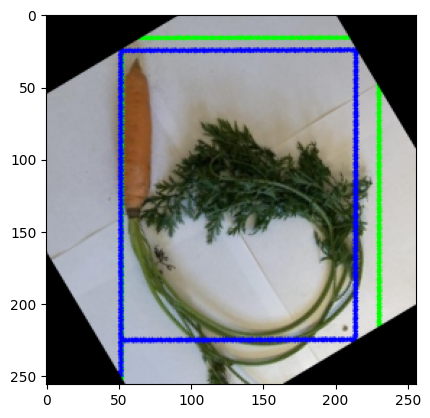

In [61]:
show_image_plt(imutils.rotate(vegi_new, rect[2]))

In [58]:
num = float(erg[0])
num

-1.0561645076546788